In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.pipeline import Pipeline

## Dimensionality reduction and Visualization

Preparing data

In [2]:
df = pd.read_csv('data/Tree_Data.csv')
df_clean = df.drop(['No',
                    'Light_Cat',
                    'Core',
                    'PlantDate',
                    'Adult',
                    'EMF',
                    'Census',
                    'Harvest',
                    'Alive',
                    'Time'],axis = 1)
df_clean.dropna(inplace=True)
df_clean.reset_index(drop=True, inplace=True)
df_clean['Plot'] = df_clean['Plot'].astype('object')
# df_clean.info()
df_clean.head()

,Plot,Subplot,Species,Light_ISF,Soil,Sterile,Conspecific,Myco,SoilMyco,AMF,Phenolics,Lignin,NSC,Event
0,1,C,Acer saccharum,0.106,Prunus serotina,Non-Sterile,Heterospecific,AMF,AMF,22.00,-0.56,13.86,12.15,1.0
1,1,C,Quercus alba,0.106,Quercus rubra,Non-Sterile,Heterospecific,EMF,EMF,15.82,5.19,20.52,19.29,0.0
2,1,C,Quercus rubra,0.106,Prunus serotina,Non-Sterile,Heterospecific,EMF,AMF,24.45,3.36,24.74,15.01,1.0
3,7,D,Acer saccharum,0.080,Prunus serotina,Non-Sterile,Heterospecific,AMF,AMF,22.23,-0.71,14.29,12.36,1.0
4,14,A,Acer saccharum,0.060,Prunus serotina,Non-Sterile,Heterospecific,AMF,AMF,21.15,-0.58,10.85,11.20,1.0


In [3]:
preprocessing = make_column_transformer(
    (StandardScaler(), make_column_selector(dtype_include=np.number)),
    (OneHotEncoder(handle_unknown='ignore'), make_column_selector(dtype_include=object))
)

X, y = df_clean.iloc[:, :-1], df_clean.iloc[:, -1:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = preprocessing.fit_transform(X_train).toarray()
X_test = preprocessing.transform(X_test).toarray()

y_train, y_test = y_train.values, y_test.values

print(f"Train data shape = {X_train.shape}, train target shape = {y_train.shape}")
print(f"Test data shape = {X_test.shape}, test target shape = {y_test.shape}")

Train data shape = (2225, 49), train target shape = (2225, 1)
Test data shape = (557, 49), test target shape = (557, 1)


Dimensionality reduction

In [4]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

In [5]:
pca = PCA(n_components=2)
X2D_pca = pca.fit_transform(X_train)

tsne = TSNE(n_components=2, random_state=42)
X2D_tsne = tsne.fit_transform(X_train)

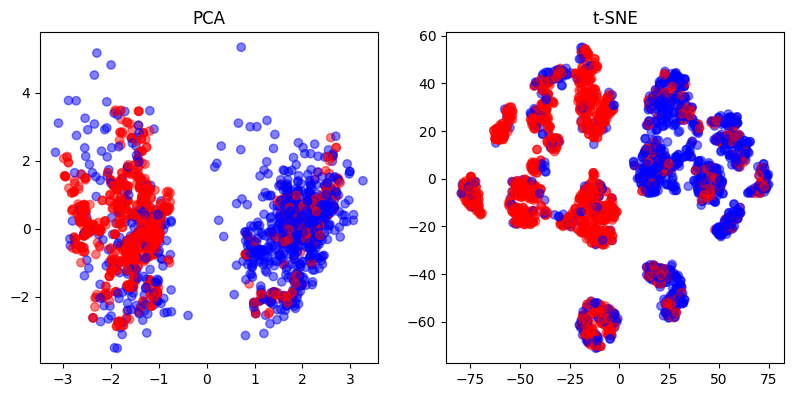

In [6]:
plt.figure(figsize=(9.6, 4.3))
custom_cmap = ListedColormap(['blue', 'red'])

plt.subplot(1, 2, 1)
plt.scatter(X2D_pca[:, 0], X2D_pca[:, 1], c=y_train[:, 0], cmap=custom_cmap, alpha=0.5)
plt.title('PCA')

plt.subplot(1, 2, 2)
plt.scatter(X2D_tsne[:, 0], X2D_tsne[:, 1], c=y_train[:, 0], cmap=custom_cmap, alpha=0.5)
plt.title('t-SNE')

plt.show()

## Cluster analysis

In [7]:
from sklearn.cluster import KMeans
import cv2

In [8]:
def optimal_colors(img, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, n_init="auto").fit(np.reshape(img, (-1, 3)))
    colors = kmeans.cluster_centers_.astype('uint8')
    return colors

def dith_img(img, colors):
    img_tmp = np.copy(img).astype(float)
    rows, cols, _ = img.shape
    dithering = np.zeros_like(img)
    for r in range(1, rows-1):
        for c in range(1, cols-1):
            pixel = img_tmp[r, c, :]
            new_pixels =  np.sqrt(np.sum((colors - pixel)**2, axis=1))
            new_pixel = colors[np.argmin(new_pixels), :]
            quant_error = pixel - new_pixel

            img_tmp[r + 1, c - 1, :] += 3/16 * quant_error
            img_tmp[r + 1, c    , :] += 5/16 * quant_error
            img_tmp[r + 1, c + 1, :] += 1/16 * quant_error
            img_tmp[r    , c + 1, :] += 7/16 * quant_error
            
            dithering[r, c, :] = new_pixel
    return dithering

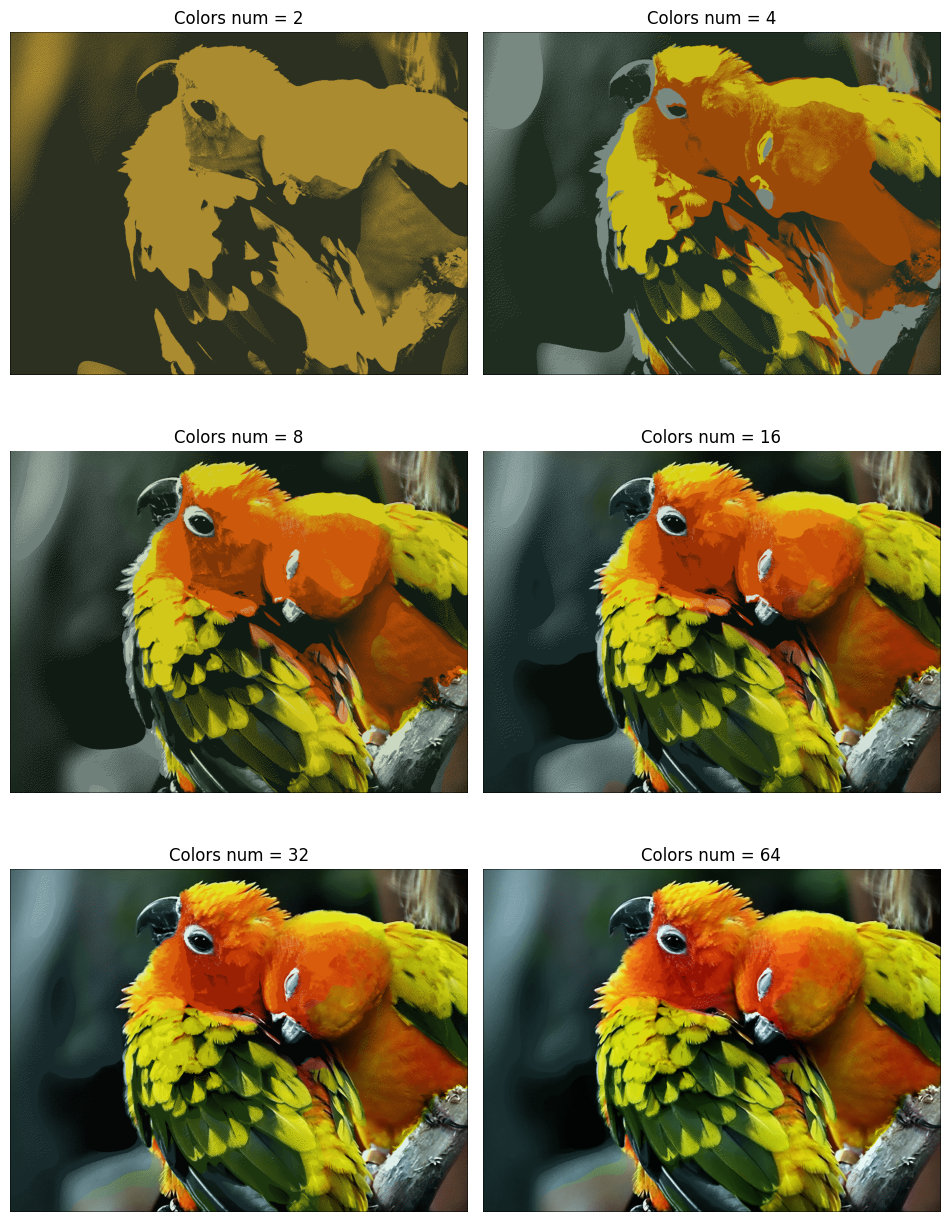

In [9]:
img = cv2.imread('data/popugaj.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(9.6, 3 * 4.3))
for i in range(1, 7):
    colors = optimal_colors(img, n_clusters=2**i)
    img_dith = dith_img(img, colors)
    plt.subplot(3, 2, i)
    plt.title(f'Colors num = {2**i}')
    plt.axis("off")
    plt.imshow(img_dith)
plt.tight_layout()
plt.show()

## Text data processing and classification

In [17]:
import tensorflow as tf
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, LSTM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [11]:
df = pd.read_csv('data/words.csv')
df = df.drop(['Unnamed: 0', 'count', 'hate_speech',
                    'offensive_language', 'neither'],axis = 1)
df = df[['tweet', 'class']]
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,tweet,class
0,!!! RT @mayasolovely: As a woman you shouldn't...,2
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1


In [12]:
# Data preparation
df['tweet'] = df['tweet'].str.replace(r'^.*?:\s*', '', regex=True)
df_temp = df.copy()
df['tweet'] = df['tweet'].str.replace(r'@\w+', 'person', regex=True)
df['tweet'] = df['tweet'].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True).str.lower()
df_temp['tweet'] = df_temp['tweet'].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True).str.lower()
df['class'] = df['class'].replace(2, 0)

df.head()

,tweet,class
0,as a woman you shouldnt complain about cleanin...,0
1,boy dats coldtyga dwn bad for cuffin dat hoe i...,1
2,you ever fuck a bitch and she start to cry you...,1
3,person she look like a tranny,1
4,the shit you hear about me might be true or it...,1


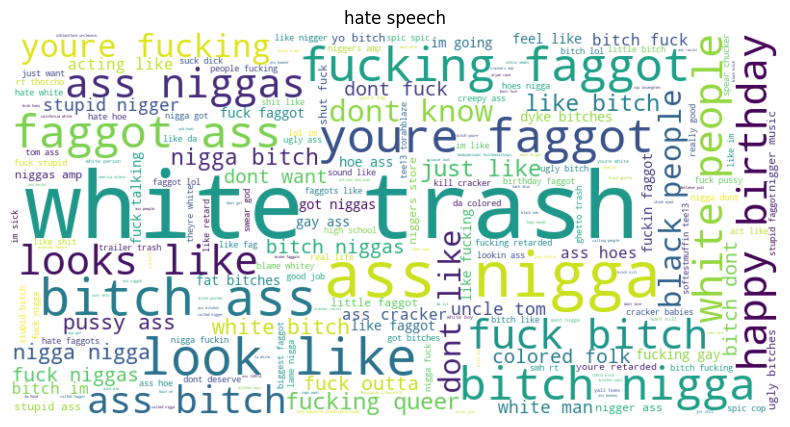

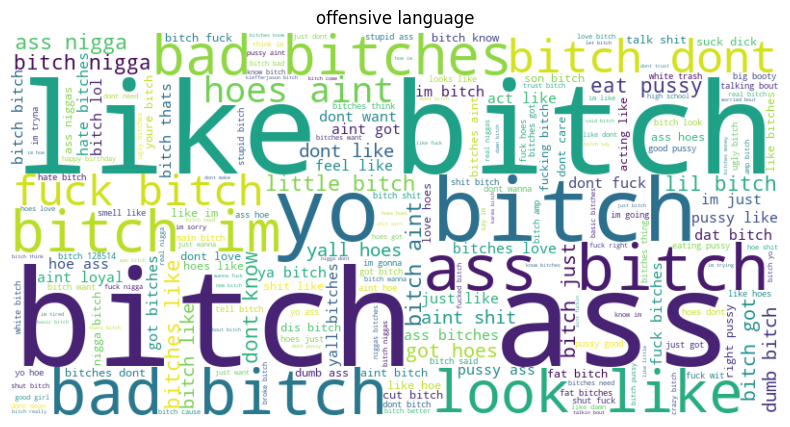

In [13]:
def generate_wordclouds_by_class(df, text_column, class_column, ngram_range=(1, 1)):
    classes = [0, 1]
    class_names = ['hate speech', 'offensive language', 'neither']
    
    for cls in classes:
        texts = df[df[class_column] == cls][text_column]
        vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english')
        ngrams = vectorizer.fit_transform(texts)
        ngram_counts = dict(zip(vectorizer.get_feature_names_out(), ngrams.toarray().sum(axis=0)))
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(ngram_counts)
        
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'{class_names[cls]}')
        plt.show()

generate_wordclouds_by_class(df_temp, text_column='tweet', class_column='class', ngram_range=(2, 2))

In [14]:
vocab_size = 5000
embedding_dim = 64
max_length = 20
trunc_type = 'post'
padding_type = 'post'

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df['tweet'])
sequences = tokenizer.texts_to_sequences(df['tweet'])
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df['class'])

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

In [18]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

y_pred = nb_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.6080290498285253
Precision: 0.7844022884673291
Recall: 0.6798016701461378
F1 Score: 0.7283657206766393
